## Supervised learning & unsupervised learning: MNIST as an example

In [53]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns; 
import time

import warnings
warnings.filterwarnings("ignore")

## Try PCA for clustering first:

In [26]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [27]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print('Original Data Dimensions:', digits.data.shape)
print('Projected Shape:', projected.shape)

Original Data Dimensions: (1797, 64)
Projected Shape: (1797, 2)


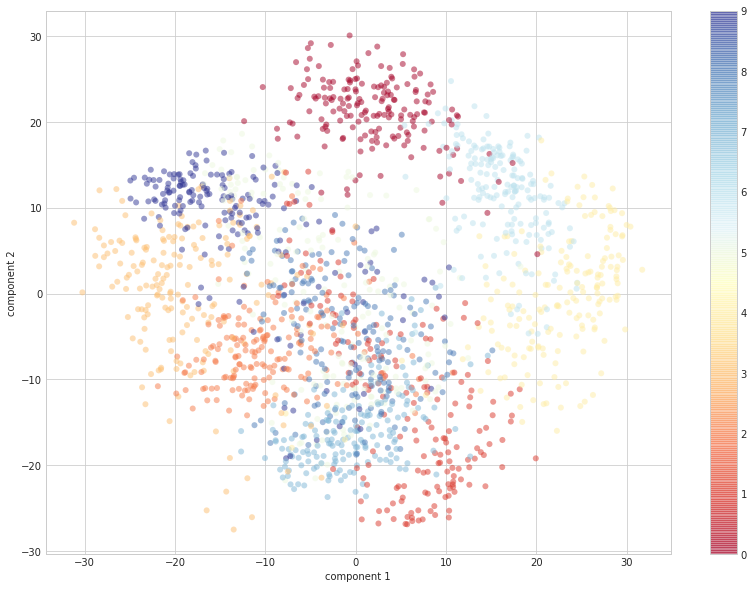

In [34]:
fig = plt.figure(figsize=(14,10))
ax = plt.axes()

s = ax.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('RdYlBu'))
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
fig.colorbar(s, ax=ax)

## PCA as Noise Filtering

#### Look at original dataset first:

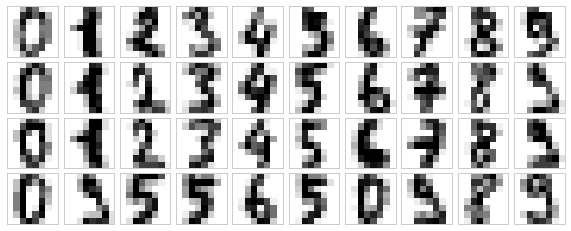

In [35]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

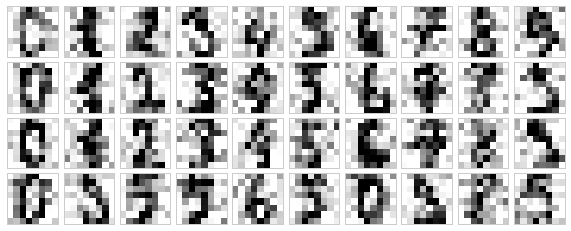

In [6]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

Not only can we generate PCA based on components, but can also do that based on explained variance ratio.

In [37]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

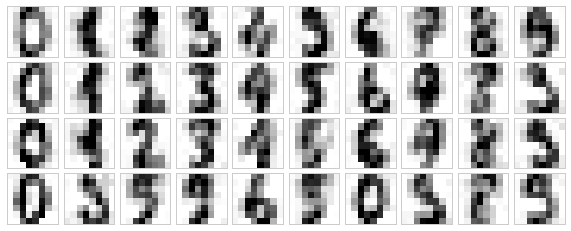

In [38]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

### Now lets do it on larger dataset

In [39]:
from sklearn.datasets import fetch_openml
X,y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [40]:
X.data.shape

(70000, 784)

In [41]:
y.shape

(70000,)

In [42]:
train_data, test_data, train_label, test_label = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [43]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_data)

# Apply transform to both the training set and the test set.
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

Initialize a benchmarking data frame:
Let’s initialize a pandas data frame that would hold:

Variance: The variance of the original data that is retained
N_component: number of principal components
Timing: time to fit training
Accuracy: Percentage of records correctly classified.
We will capture the above attributes from each experiment run.

In [55]:
benchmark_cols = ['Variance retained','n_Components','Time(s)','Accuracy_percentage']
benchmark = pd.DataFrame(columns = benchmark_cols)
benchmark

,Variance retained,n_Components,Time(s),Accuracy_percentage


Just applying logistic regression:

In [54]:
variance = 1.0
n_components = train_data.shape[1]

logisticRegr = LogisticRegression()
start = time.time()
logisticRegr.fit(train_data, train_label)
end =  time.time()
timing = end-start
# Predict for Multiple Observations (images) at Once
predicted = logisticRegr.predict(test_data)
# generate evaluation metrics
accuracy = (metrics.accuracy_score(test_label, predicted))


In [56]:

a = dict(zip(benchmark_cols,[variance,n_components,timing,accuracy]))
benchmark = benchmark.append(a,ignore_index=True)
benchmark

,Variance retained,n_Components,Time(s),Accuracy_percentage
0,1.0,784.0,23.406892,0.917214


How long it takes 

In [18]:
variance_list = [0.95, 0.90, 0.85, 0.80, 0.75, 0.70]

In [57]:
def benchmark_pca(variance,train_data,train_label,test_data,test_label):
    global benchmark
    pca = PCA(variance)
    pca.fit(train_data)
    
    n_components = pca.n_components_
    train_data = pca.transform(train_data)

    # pca.fit(test_data)
    test_data = pca.transform(test_data)
    LR = LogisticRegression()
    start = time.time()
    LR.fit(train_data, train_label)
    end =  time.time()
 
    timing = end-start   

    # Predict for Multiple Observations (images) at Once
    predicted = LR.predict(test_data)   

    # generate evaluation metrics
    accuracy = (metrics.accuracy_score(test_label, predicted))
    #return 
    a = dict(zip(benchmark_cols,[variance,n_components,timing,accuracy]))
    benchmark = benchmark.append(a,ignore_index=True)

for variance in variance_list:
    benchmark_pca(variance,train_data,train_label,test_data,test_label)

In [58]:
benchmark

,Variance retained,n_Components,Time(s),Accuracy_percentage
0,1.00,784.0,23.406892,0.917214
1,0.95,154.0,7.060090,0.912071
2,0.90,87.0,5.689040,0.907500
3,0.85,59.0,5.128969,0.903286
4,0.80,43.0,4.834693,0.898071
5,0.75,33.0,4.721689,0.891929
6,0.70,26.0,4.509806,0.882714


Text(0.5, 1.0, 'variance vs accuracy')

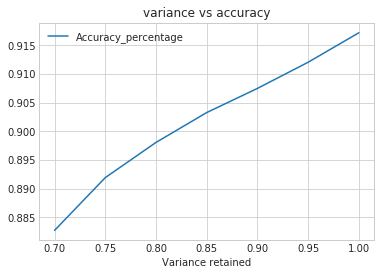

In [59]:
benchmark.plot(x=0,y=-1)
plt.title("variance vs accuracy")

Text(0.5, 1.0, 'no of components vs accuracy')

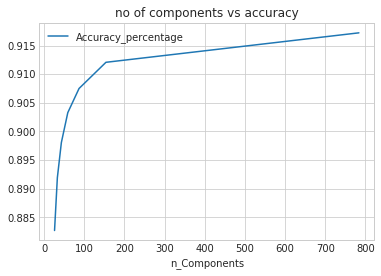

In [60]:
benchmark.plot(x=1,y=-1)
plt.title("no of components vs accuracy")

Text(0.5, 1.0, 'time vs accuracy')

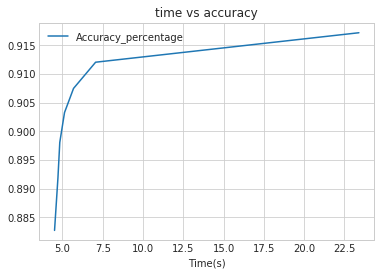

In [61]:
benchmark.plot(x=2,y=-1)
plt.title("time vs accuracy")